# Impact of Marketing Strategies on Guest Behaviour

This notebook contains the Python code, visualizations and results used to analyze the impact of marketing strategies on guest behaviour.

## Part I: Analyze past campaign data to study changes in guest satisfaction
In this section, we will be using 2 datasets for the analysis:
1. `universal_studios_branches.csv`: Reviews of Universal Studios from Kaggle
2. `uss_promo_events.csv`: Compiled list of past promotional events in Universal Studios Singapore

Since there are no publicly available data on campaign success (e.g. Social media engagement metrics, Return on Investment) for amusement parks, we will use the following metrics to gauge the impact of promotional events on guest satisfaction:
1. `review_volume_change`: Change in average review volume before vs. during the event period
    - Used as a measure of engagement rate
    - Higher volume of reviews during the event would suggest higher engagement
2. `review_polarity_change`: Change in average review sentiment before vs. during the event period
    - Measure of public perception and sentiment towards the event
    - Positive polarity change during the event suggest improved brand perception
3. `review_ratings_change`: Change in average review ratings before vs. during the event period
    - Used to measure overall guest satisfaction
    - An increase in ratings suggests improved guest experience and satisfaction during the event

Statistical tests will be performed on the above metrics to assess whether the event periods had significant impact on guest satisfaction.
- Methods such as paired t-test or Wilcoxon signed-rank test will be performed

### Import packages and datasets

In [3]:
import kagglehub
import pandas as pd
import os
from datetime import datetime, timedelta
from emoji import demojize
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# (1) Import uss_promo_events.csv
events_path = os.path.join("../data/raw data/uss_promo_events.csv")
print("Path to dataset:", events_path)
df_events = pd.read_csv(events_path)

# (2) Download and import universal_studio_branches.csv
kaggle_download_path = kagglehub.dataset_download("dwiknrd/reviewuniversalstudio")
print("Path to dataset:", kaggle_download_path)

reviews_path = os.path.join(kaggle_download_path, "universal_studio_branches.csv")
df_reviews = pd.read_csv(reviews_path)

Path to dataset: ../data/raw data/uss_promo_events.csv
Path to dataset: /Users/jolene/.cache/kagglehub/datasets/dwiknrd/reviewuniversalstudio/versions/1


### Data cleaning and preprocessing

In [4]:
# ----- Data cleaning ----- #
# (1) Check for missing values
def handle_missing_values(df, drop=True, fill_value=None):
    missing_counts = df.isnull().sum()
    if missing_counts.sum() == 0:
        print("No missing values found.")
        return df
    print("Missing values per column:\n", missing_counts)
    if drop:
        df = df.dropna()
        print("Dropped rows with missing values.")
    elif fill_value is not None:
        df = df.fillna(fill_value)
        print(f"Filled missing values with {fill_value}.")

    return df

df_reviews = handle_missing_values(df_reviews)
df_events = handle_missing_values(df_events)

# (2) Convert dates to datetime type
df_reviews["written_date"] = pd.to_datetime(df_reviews["written_date"], errors='coerce')
df_events["start"] = pd.to_datetime(df_events["start"], format='%b %d, %Y', errors='coerce')
df_events["end"] = pd.to_datetime(df_events["end"], format='%b %d, %Y', errors='coerce')

df_events = df_events.sort_values("start")  # order events by start date

# (3) Handle duplicates
def remove_duplicates(df):
    # check if there are duplicated rows
    dup_count = df.duplicated().sum()
    print(f"Number of duplicate rows: {dup_count}")

    # drop duplicates if any
    if dup_count > 0:
        df.drop_duplicates(inplace=True)
        print("Duplicates removed.")
    else:
        print("No duplicates found.")
    return df

df_reviews = remove_duplicates(df_reviews)
df_events = remove_duplicates(df_events)

# (4) Compute event duration
df_events["duration"] = (df_events["end"] - df_events["start"]).dt.days

# --- Sentiment analysis --- #
# Using TextBlob to compute the polarity scores
# We will be analysing the 'combined_text' = review title + text

# Combine the text columns
df_reviews['combined_text'] = df_reviews['title'] + " " + df_reviews['review_text']
df_reviews = df_reviews.drop(columns=['title', 'review_text'])


# (1) Text preprocessing: convert emojis
df_reviews["combined_text"] = df_reviews["combined_text"].apply(lambda text: demojize(text))

# (2) TextBlob: compute polarity scores
from textblob import TextBlob

def analyse_sentiment(df, text_column):
    df["polarity"] = df[text_column].apply(lambda text: TextBlob(text).sentiment.polarity)
    return df

df_reviews = analyse_sentiment(df_reviews, 'combined_text')

# --- Segment review data --- #
# Segment review data into reviews written before the event vs. reviews written during the event

# (1) Define function to filter for reviews written DURING event period
def filter_reviews_during_events(reviews, events, branch = 'Universal Studios Singapore'):
    event_reviews_dict = {}

    for _, event in events.iterrows():
        event_key = f"{event['event']} ({event['start'].date()})"  # event as unique key
        start = event["start"]
        end = event["end"]

        filtered_reviews = reviews[
            (reviews["written_date"] >= start) &
            (reviews["written_date"] <= end) &
            (reviews["branch"] == branch)
        ]

        event_reviews_dict[event_key] = filtered_reviews

    return event_reviews_dict

# (2) Define function to filter for reviews written BEFORE event period
def filter_reviews_before_events(reviews, events, branch = 'Universal Studios Singapore'):
    event_reviews_dict = {}
    for _, event in events.iterrows():
        event_key = f"{event['event']} ({event['start'].date()})"  # event as unique key

        # set the period before event to have the same duration for fair comparison
        start = event["start"] - timedelta(days=event["duration"])
        end = event["start"] - timedelta(days=1)

        filtered_reviews = reviews[
            (reviews["written_date"] >= start) &
            (reviews["written_date"] <= end) &
            (reviews["branch"] == branch)
        ]

        event_reviews_dict[event_key] = filtered_reviews

    return event_reviews_dict

# Call both functions to create 2 filtered dictionaries
# Structure of filtered dictionaries: {event_key: [df of filtered reviews]}
reviews_during_events = filter_reviews_during_events(df_reviews, df_events)
reviews_before_events = filter_reviews_before_events(df_reviews, df_events)

No missing values found.
No missing values found.
Number of duplicate rows: 45
Duplicates removed.
Number of duplicate rows: 0
No duplicates found.


### Data Analysis


In [5]:
# (1) Compute difference in key metrics before event vs during event
def compute_change_in_reviews(reviews_before_event, reviews_during_event):
    changes = {}
    for event, reviews_before in reviews_before_event.items():
        # Get reviews during the event from the second dictionary
        reviews_during = reviews_during_event.get(event)
        if reviews_during is not None:
            # Ensure the reviews are DataFrames before performing calculations
            reviews_before = pd.DataFrame(reviews_before)
            reviews_during = pd.DataFrame(reviews_during)

            # Calculate average polarity score, review rating, and review volume before and during the event
            before_avg = reviews_before[['polarity', 'rating']].mean()
            during_avg = reviews_during[['polarity', 'rating']].mean()
            before_volume = len(reviews_before)
            during_volume = len(reviews_during)

            # Calculate change in polarity score, review rating, and review volume
            change = {
                'review_polarity_change': during_avg['polarity'] - before_avg['polarity'],
                'review_rating_change': during_avg['rating'] - before_avg['rating'],
                'review_volume_change': during_volume - before_volume
            }
            changes[event] = change

    # Convert to df for easier analysis
    df_changes = pd.DataFrame.from_dict(changes, orient='index')
    print(df_changes)
    return df_changes

df_change_data = compute_change_in_reviews(reviews_before_events, reviews_during_events)

                                  review_polarity_change  \
Maybank Promo (2016-01-01)                      0.007546   
Mastercard Promo (2016-01-04)                   0.007557   
NTUC Members Promo (2016-05-21)                -0.113321   
NSmen Promo (2016-06-26)                        0.038732   
Mastercard Promo (2016-08-01)                   0.002207   
USS Promo (2016-09-01)                          0.034162   
USS Promo (2017-01-03)                         -0.024029   
NSmen Promo (2017-07-01)                       -0.010040   
Maybank Promo (2018-03-01)                      0.017481   
SAF Day Promo (2018-07-01)                     -0.032227   
Maybank Promo (2019-03-01)                      0.020871   
Mastercard Promo (2019-03-18)                   0.009326   
Mastercard Promo (2019-05-16)                  -0.028843   
USS Christmas Event (2019-12-02)               -0.025868   
Mastercard Promo (2020-03-07)                  -0.054887   
Mastercard Promo (2020-08-01)           

In [6]:
# (2) Statistical analysis - understand whether event periods bring about statistically significant changes

# Metrics to analyse
metrics = {
    "Review Rating Change": "review_rating_change",
    "Review Polarity Change": "review_polarity_change",
    "Review Volume Change": "review_volume_change"
}

for metric_name, col in metrics.items():
    changes = df_change_data[col]

    # Check normality using Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(changes)
    print(f"Shapiro-Wilk Test for {metric_name}: p-value = {shapiro_p:.4f}")

    # Choose appropriate test based on normality
    if shapiro_p >= 0.05:
        # Normally distributed: use one-sample t-test
        test_stat, p_value = stats.ttest_1samp(changes, 0)
        test_type = "T-test"
    else:
        # Not normally distributed: Use Wilcoxon signed-rank test
        test_stat, p_value = stats.wilcoxon(changes)
        test_type = "Wilcoxon Test"

    # Print test results
    print(f"{metric_name} ({test_type}): Test-statistic = {test_stat:.4f}, P-value = {p_value:.4f}")

    # Print interpretation
    if p_value < 0.05:
        print(f"Significant change detected in {metric_name} before vs. during the event.\n")
    else:
        print(f"No significant change in {metric_name} before vs. during the event.\n")

Shapiro-Wilk Test for Review Rating Change: p-value = 0.0000
Review Rating Change (Wilcoxon Test): Test-statistic = 61.0000, P-value = 0.7436
No significant change in Review Rating Change before vs. during the event.

Shapiro-Wilk Test for Review Polarity Change: p-value = 0.4619
Review Polarity Change (T-test): Test-statistic = -0.2532, P-value = 0.8035
No significant change in Review Polarity Change before vs. during the event.

Shapiro-Wilk Test for Review Volume Change: p-value = 0.5420
Review Volume Change (T-test): Test-statistic = -1.1166, P-value = 0.2818
No significant change in Review Volume Change before vs. during the event.



Insight: There is no significant change in review volume, rating and polarity before vs during promotional events.


### Data Visualization

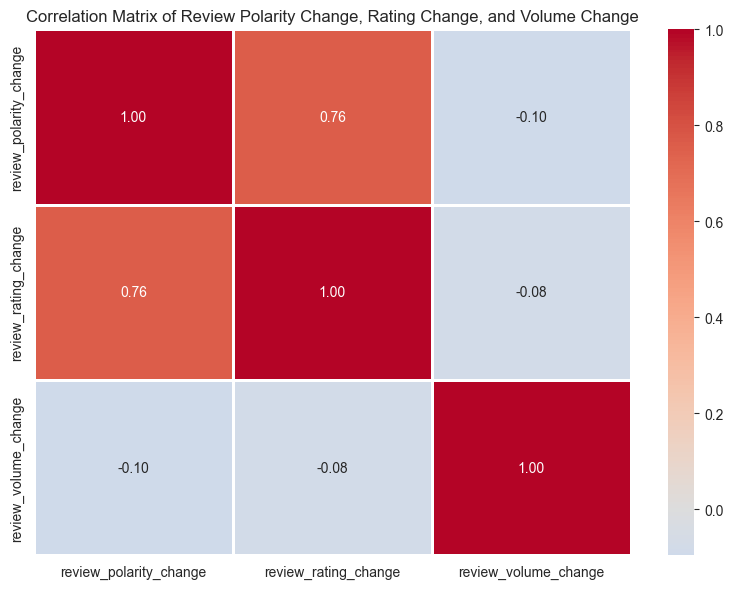

In [8]:
# (1) Correlation matrix
correlation_matrix = df_change_data[['review_polarity_change', 'review_rating_change', 'review_volume_change']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1, fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Review Polarity Change, Rating Change, and Volume Change')
plt.tight_layout()
plt.show()

Insights from correlation matrix:
1. Review Volume and Sentiment (-0.10), Review Volume and Ratings (-0.08):
    - Negligible negative correlation, which suggest that more reviews does not reflect guest satisfaction.
    - While an increase in review volume typically signals higher engagement and interest in the campaign, it is not sufficient on its own to gauge guest satisfaction.
    - To assess a campaign’s true impact, other factors, such as review sentiment and ratings, should be considered.

2. Ratings and Sentiment (0.76)
    - Positive correlation, which indicates that higher ratings reflect better guest experience.
    - To strengthen brand perception during event periods, campaigns should aim to create memorable experiences that not only generate reviews but also result in high ratings.

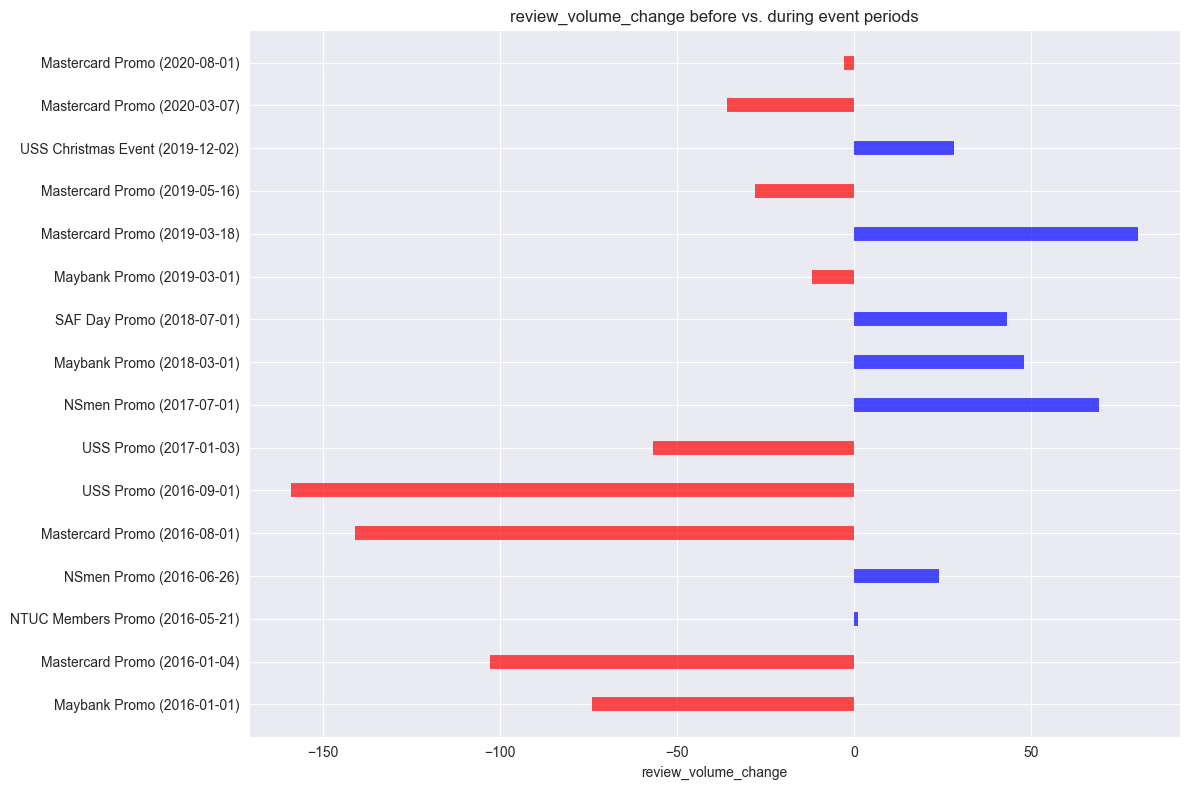

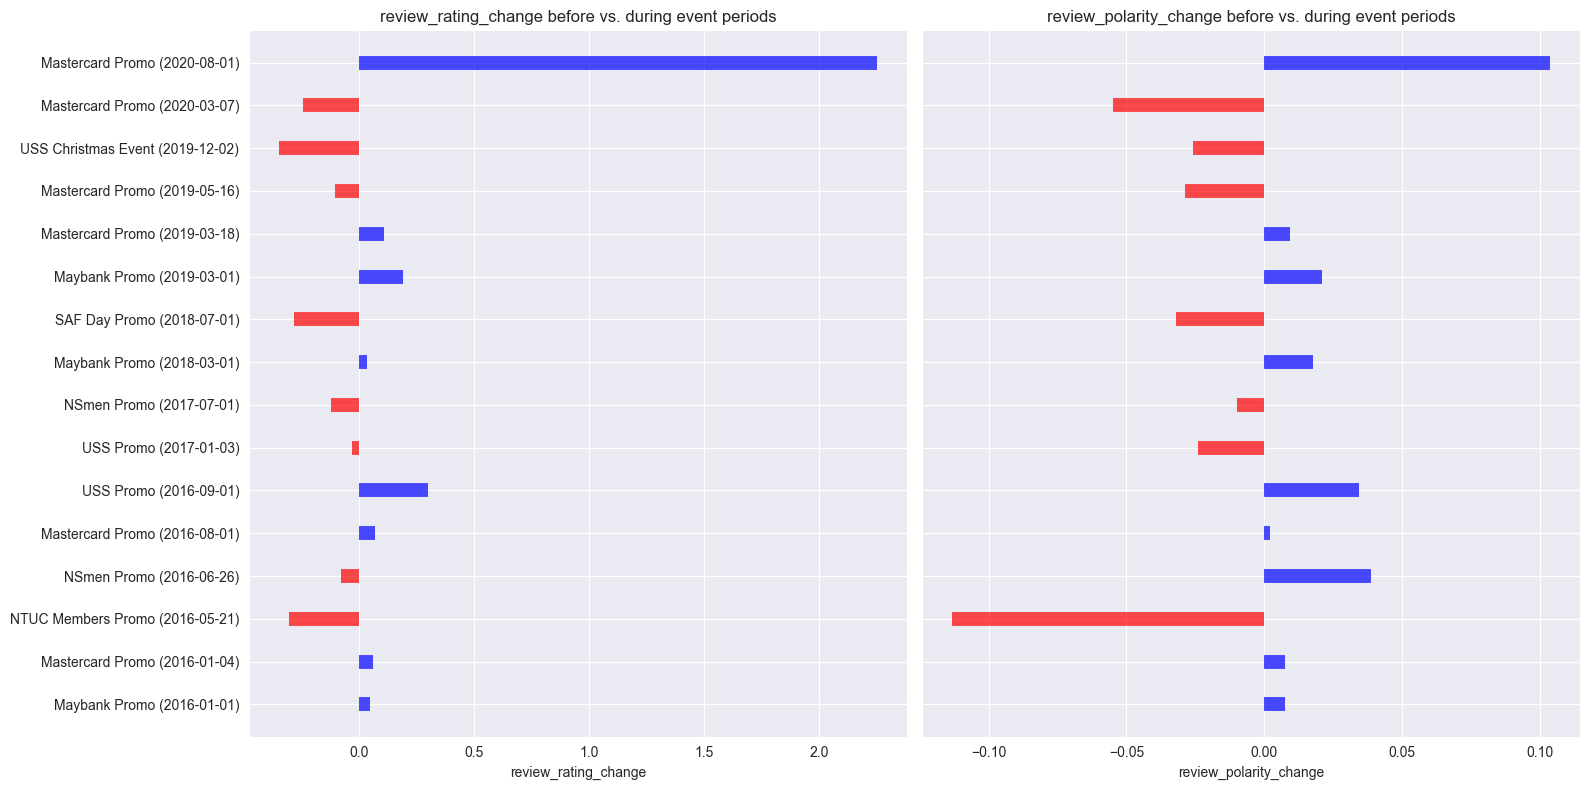

In [10]:
# (2) Visualize change using diverging bar plot
def plot_review_change(ax, change_data, diff_col):
    event_names = change_data.index.values
    avg_change = change_data[diff_col]

    df = pd.DataFrame({'event': event_names, 'difference': avg_change})
    df['color'] = df['difference'].apply(lambda x: 'red' if x < 0 else 'blue')

    ax.hlines(y=df.index, xmin=0, xmax=df['difference'], color=df['color'], alpha=0.7, linewidth=10)
    ax.set_yticks(df.index)
    ax.set_yticklabels(df['event'])
    ax.set_xlabel(diff_col)
    ax.set_title(f"{diff_col} before vs. during event periods")

# (i) Plot for review_volume_change
fig, ax = plt.subplots(figsize=(12, 8))
plot_review_change(ax, df_change_data, "review_volume_change")
plt.tight_layout()
plt.show()

# (ii) Side-by-Side plot comparing review_polarity_change and review_rating_change
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plot_review_change(axes[0], df_change_data, "review_rating_change")
plot_review_change(axes[1], df_change_data, "review_polarity_change")
plt.tight_layout()
plt.show()

Insights from visualizations:
1. Plot of `review_volume_change` before vs during events:
    - Comparing to the plots on `review_rating_change` and `review_polarity_change`, there is no visible trend. This
    aligns with our insights from the correlation matrix.

2. Side-by-Side Plot of `review_rating_change` and `review_polarity_change`:
    - Based on the plot, we can see that `review_rating_change` and `review_polarity_change` follow the same trend. This
    aligns with our insights from the correlation matrix.


### Summary
#### Insights
 - No significant change detected in review volume, rating and sentiment (polarity) before vs during promotional events periods at USS.
 - This suggests that promotional events by USS did not significantly affect review volume, ratings, or sentiment, indicating that current marketing strategies may not be effectively influencing guest satisfaction during events.

#### Business Impact
- The lack of significant changes suggests USS' current marketing strategies do not strongly influence guest satisfaction during events.
- Campaign success should not be judged solely on engagement metrics (e.g., review volume). Instead, USS should focus on improving guest experiences that drive both positive sentiment and high ratings.


## Part II: Recommend tailored marketing strategies for specific segments
In this section, we will be using the Guest Segmentation Model developed from Question 2 to examine how various guest segments learnt about USS, their advertisement exposure and their preferred promotion type.

### Intialize Guest Segmentation Model




In [25]:
from Scripts.Subgroup_A.datapreparation_A import *
from Scripts.Subgroup_A.modeling.q2_guest_segmentation_model import guest_segmentation_model
%matplotlib agg
import io
from contextlib import redirect_stdout, redirect_stderr

# Initialize class
df_combined, df_labeled, scaled, pca = cleaning_q2()
segmentation_analysis = guest_segmentation_model(df_combined, df_labeled, scaled, pca)

# Suppress both prints and plots for run_pipeline
with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
    segmentation_analysis.run_pipeline()
plt.close('all')

### Marketing Analysis on Guest Segments

In [26]:
segmentation_analysis.run_marketing_analysis()

---Business Question 4, Part II: Recommend tailored marketing strategies for specific segments ---
### Awareness: 'How did you first hear about Universal Studios Singapore?' ###
                    cluster      awareness
0      Social-Driven Youths  Word of mouth
1  Value-Conscious Families  Word of mouth
2   Budget-Conscious Youths  Word of mouth
3          Premium Spenders  Word of mouth


### Response to ads: 'Have you seen any recent advertisements or promotions for USS?' ###
                    cluster                              response_to_ads
0      Social-Driven Youths  Yes, but they did not influence my decision
1  Value-Conscious Families                   No, I haven't seen any ads
2   Budget-Conscious Youths  Yes, but they did not influence my decision
3          Premium Spenders                   No, I haven't seen any ads


### Preferred promotion: 'What type of promotions or discounts would encourage you to visit USS?' ###
                    cluster preferred_promotio

### Summary
#### Insight 1:
Across all segments, word-of-mouth emerged as the primary awareness source. This shows that peer recommendations and
personal experiences are much more impactful than traditional advertising.

#### Business impact 1:
- Prioritise word-of-mouth marketing through social media.
- Partner with influencers and introduce incentives for guests to share their authentic USS experience through user-generated-content. Such incentives could include a discount for their next visit or referral discounts.
---------------------------------------------------------------------------------------------------------------------
#### Insight 2:
Families had limited advertisement exposure, while youths saw advertisements but were not influenced to visit.
- Advertisements may not be reaching families through the most effective channels.
- Approach of advertisements may not be resonating with youths.

#### Business impact 2:
- Given that word-of-mouth is effective across all segments, continue to prioritise this channel.
- Collaborate with family-focused influencers or content creators to highlight the family-friendly aspects of USS,
such as kid-friendly attractions, family discounts, and safety measures.
- Engage youths with interactive campaigns on TikTok/Instagram instead of traditional advertisements. For example,
offering behind-the-scenes exclusives or guest interviews can be a starting point to build an online community,
foster a sense of inclusivity and build rapport with guests.
---------------------------------------------------------------------------------------------------------------------
#### Insight 3:
Discounts are the most preferred promotion type, but analysis of past promotional events showed no significant impact on
guest satisfaction. This highlights a need to shift toward focusing on guest experience instead.

#### Business impact 3:
Shift focus from discounts to creating unique, memorable experiences for guests.
For instance,
- Lucky draw events where winner gets exclusive backstage access or meet-and-greet opportunities.
- Exclusive polaroid photo sessions at iconic spots in USS, offering guests a tangible souvenir that adds a personal touch.
By leaving guests with memorable experiences that go beyond discount, guest are more likely to share their experience
with others, driving promotion and brand awareness through word-of-mouth.